# Task

With AI-modelling and Data Science there is plenty of opportunity to improve processes or suggest improved ways of doing things. When doing so it is often very smart and efficient (time is a scarce resource) to create a POC (Proof of Concept) which basically is a small demo checking wether it is worthwile going further with something. It is also something concrete which facilitates discussions, do not underestimate the power of that. 

In this example, you are working in a company that sells houses and they have a "manual" process of setting prices by humans. You as a Data Scientist can make this process better by using Machine Learning. Your task is to create a POC that you will present to your team colleagues and use as a source of discussion of wether or not you should continue with more detailed modelling. 

Two quotes to facilitate your reflection on the value of creating a PoC: 

"*Premature optimization is the root of all evil*". 

"*Fail fast*".


**More specifially, do the following:**
1. A short EDA (Exploratory Data Analysis) of the housing data set.
2. Drop the column `ocean_proximity`, then you only have numeric columns which will simplify your analysis. Remember, this is a POC! 
3. You have missing values in your data (not sure you do but you can assume so). Handle this with `SimpleImputer(strategy="median")`. (Check the fantastic Scikit-learn documentation for details.) Notice, the `SimpleImputer` should only be used for transformation on the validation and test data, not fitting.
4. Split your data into `X` and `y`, and then into train, validation and test sets. 
5. Create one `LinearRegression` model and one `Lasso` model. For the `Lasso` model, use `GridSearchCV` to optimize $\alpha$ values. Choose yourself which $\alpha$ values to evaluate.
Use RMSE as a metric to decide which model to choose. 

6. Which model is best on the validation data? 

7. Evaluate your chosen model on the test set using the root mean squared error (RMSE) as the metric. 
What are your conclusions? Note: to be 100% sure, you should re-fit your chosen model on the combination of train+val data. 

8. Do a short presentation (~ 2-5 min) on your POC that you present to your colleagues (no need to prepare anything particular, just talk from the code). Think of:
- What do you want to highlight/present?
- What is your conclusion?
- What could be the next step? Is the POC convincing enough or is it not worthwile continuing? Do we need to dig deeper into this before taking some decisions?

------------
Bonus question for those who have time and are ambitious: Redo everything above (copy your code) but in step 2, include the column `ocean_proximity` which is a categorical column. 

# Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('husl')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import root_mean_squared_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
# Below, set your own path where you have stored the data file if it is not in the /data folder. 
housing = pd.read_csv(r'data/housing.csv')

## EDA

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.shape

(20640, 10)

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
housing.columns.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [8]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
housing.nunique()

longitude               844
latitude                862
housing_median_age       52
total_rooms            5926
total_bedrooms         1923
population             3888
households             1815
median_income         12928
median_house_value     3842
ocean_proximity           5
dtype: int64

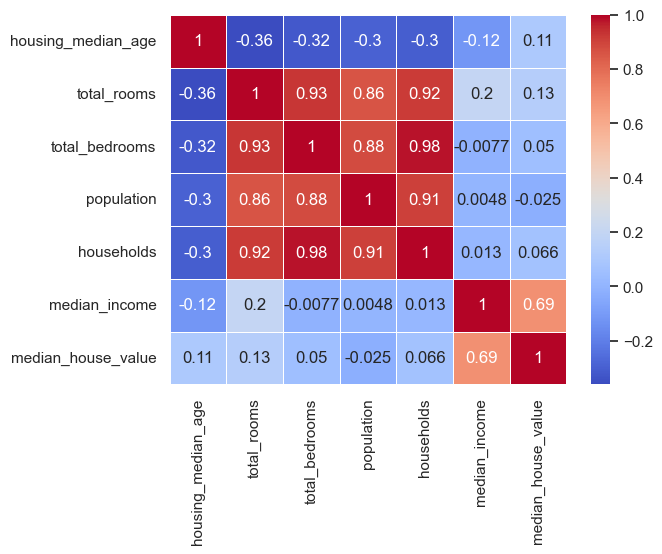

In [10]:
# Plotting the heatmap of all the numerical values, by dropping the ocean_proximity column and the latitude and longitude columns.
housing_selected = housing.drop(['ocean_proximity', 'latitude', 'longitude'], axis=1)
sns.heatmap(housing_selected.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

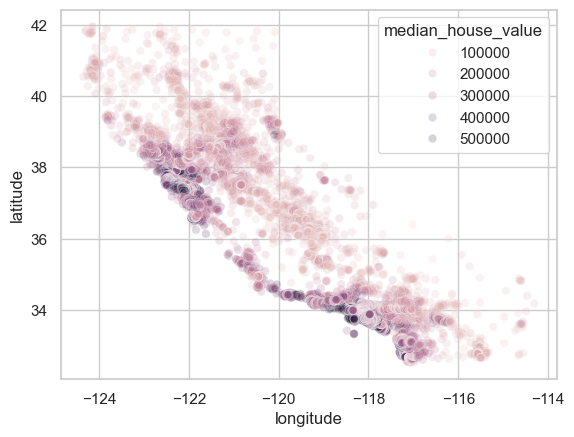

In [11]:
# Scatter plot of latitude and longitude creates a map of median house values
sns.scatterplot(x='longitude', y='latitude', data=housing, alpha=0.2, hue='median_house_value')
plt.show()

In [12]:
# Alternatively, using ydata_profiling to generate EDA report
from ydata_profiling import ProfileReport
profile = ProfileReport(housing, title='Pandas Profiling Report', explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Preparing data

In [13]:
# Dropping the ocean_proximity column as it is a categorical variable
housing = housing.drop(['ocean_proximity'], axis=1)

In [14]:
# Replacing the missing values in the total_bedrooms column with the median value   
imputer = SimpleImputer(strategy='median')
imputer.fit(housing[['total_bedrooms']])
housing['total_bedrooms'] = imputer.transform(housing[['total_bedrooms']])

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [16]:
X, y = housing.drop('median_house_value', axis=1), housing['median_house_value']

In [24]:
# Splitting the data into training, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

## Models

In [25]:
# Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

scores_lr = cross_val_score(lin_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print('RMSE for each iteration:', np.sqrt(-scores_lr))
print('RMSE:', np.sqrt(np.mean(-scores_lr)))

RMSE for each iteration: [68306.85246929 68662.50457807 68214.75873596 72125.56982441
 68676.17720086]
RMSE: 69212.90931036088


In [26]:
# Validation data
y_pred_val = lin_reg.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print('RMSE on validation set:', rmse_val)

RMSE on validation set: 70802.11982670368


In [27]:
# Lasso model
lasso = Lasso()
hyper_param_lasso = {'alpha':(1, 5, 10, 15, 20, 30, 50, 100)}
lasso_reg = GridSearchCV(lasso, hyper_param_lasso, cv = 5)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)

print(lasso_reg.best_params_)

{'alpha': 20}


In [28]:
scores_lasso = cross_val_score(lasso_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print('RMSE for each iteration:', np.sqrt(-scores_lasso))
print('RMSE:', np.sqrt(np.mean(-scores_lasso)))

RMSE for each iteration: [68306.85062961 68662.48358972 68214.81108686 72124.91944095
 68676.18269257]
RMSE: 69212.78064179583


In [29]:
# Validation data
y_pred_val = lasso_reg.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print('RMSE on validation set:', rmse_val)

RMSE on validation set: 70801.47858622564


## Evaluation

In [33]:
# Refitting the lasso model on the combined training and validation data
lasso = Lasso(alpha=20)
lasso.fit(X_train_full, y_train_full)
lasso_pred = lasso.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, lasso_pred))
print('RMSE on test set:', rmse_test)

RMSE on test set: 71131.52672218335


## Conclusions

Lasso model performs better than Linear Regression model by a very small margin. Both models have a large root mean squared error. At this stage neither of them give an accurate price estimate. The data have outliers that could be affecting the training and the median house price values cut off at 500000.